# Handle Multiple Remotely Sensed Images

Doing analysis over larger areas often requires the use of image mosaics (combining two or more images). This notebook shows how to achieve this functionality using rioxarray.

In [4]:
import rioxarray as rxr
import rioxarray.merge
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import numpy as np
import matplotlib.patches as patches

## Union (Mosaic) of Remotely Sensed Images

Create a union mosaic with different overlap methods. For overlapping portions we can use mean, min, max, or first pixel values.

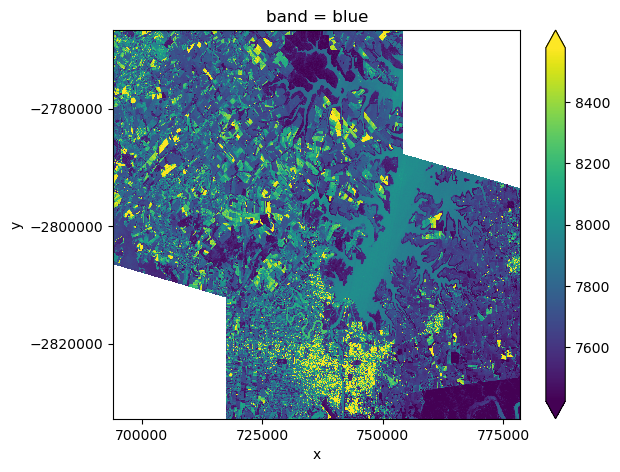

In [17]:
from os.path import basename
import matplotlib.pyplot as plt
import rioxarray as rxr
import rioxarray.merge
import numpy as np
from matplotlib.ticker import FuncFormatter

def create_mosaic_union(image_paths, overlap='first', band_idx=0):
    """Create union mosaic with specified overlap method"""
    images = [rxr.open_rasterio(path).isel(band=band_idx) for path in image_paths]
    return rioxarray.merge.merge_arrays(images, method=overlap)

# Plot union mosaic to match GeoWombat
b2_paths = [
    "../../pygis/data/LC08_L1TP_224077_20200518_20200518_01_RT_B2.TIF",
    "../../pygis/data/LC08_L1TP_224078_20200518_20200518_01_RT_B2.TIF"
]

fig, ax = plt.subplots(dpi=100)
mosaic_union = create_mosaic_union(b2_paths, overlap='first', band_idx=0)
mosaic_union.where(mosaic_union != 0).plot.imshow(robust=True, ax=ax)

ax.ticklabel_format(useOffset=False, style='plain')  # Fix coordinate formatting
ax.locator_params(axis='both', nbins=4)  # Reduce number of coordinate ticks
ax.set_title('band = blue', fontsize=12)

plt.tight_layout(pad=1)
plt.show()

## Intersection of Remotely Sensed Images

Find the intersection of two images using the overlapping area only.

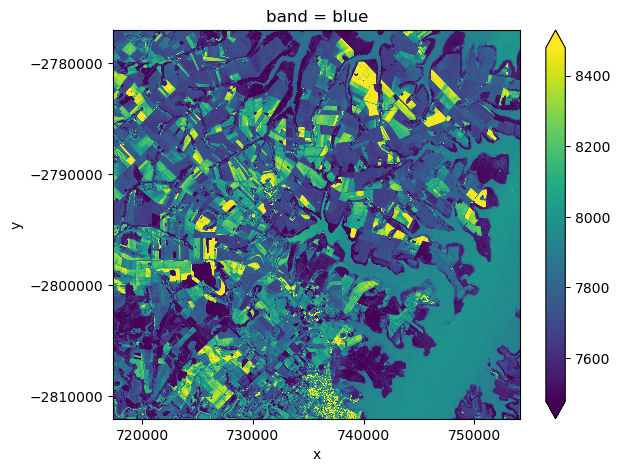

In [21]:
def create_mosaic_intersection(image_paths, overlap='max', band_idx=0):
    """Create intersection mosaic using only overlapping areas"""
    images = [rxr.open_rasterio(path).isel(band=band_idx) for path in image_paths]
    all_bounds = [img.rio.bounds() for img in images]
    
    # Calculate intersection bounds
    left = max(bounds[0] for bounds in all_bounds)
    bottom = max(bounds[1] for bounds in all_bounds)
    right = min(bounds[2] for bounds in all_bounds)
    top = min(bounds[3] for bounds in all_bounds)
    
    # Clip and merge
    clipped_images = [img.rio.clip_box(left, bottom, right, top) for img in images]
    return rioxarray.merge.merge_arrays(clipped_images, method=overlap)

# Plot intersection using max overlap
fig, ax = plt.subplots(dpi=100)
mosaic_intersection = create_mosaic_intersection(b2_paths, overlap='max', band_idx=0)
mosaic_intersection.where(mosaic_intersection != 0).plot.imshow(robust=True, ax=ax)

ax.ticklabel_format(useOffset=False, style='plain')
ax.locator_params(axis='both', nbins=4)
ax.set_title('band = blue', fontsize=12)

plt.tight_layout(pad=1)
plt.show()

## Plot LandSat Tile Footprints

Visualize the footprints of multiple image tiles to understand their spatial coverage and overlaps.

(<Figure size 700x700 with 1 Axes>,
 <Axes: title={'center': 'Satellite Tile Footprints'}>)

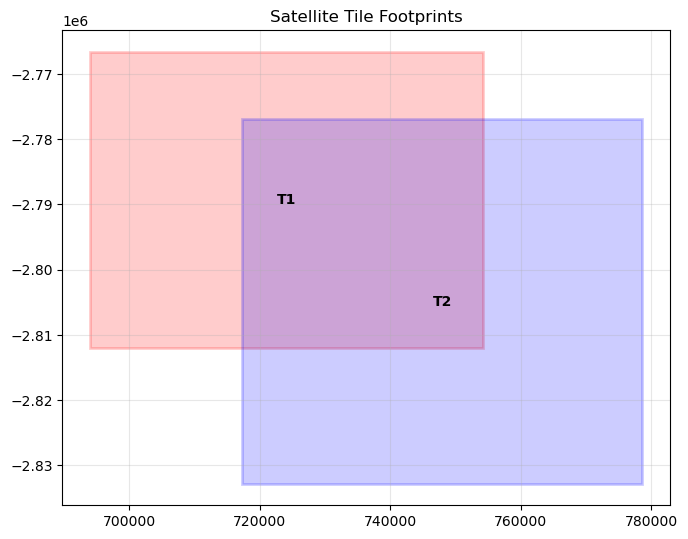

In [24]:
import matplotlib.patches as patches

def plot_footprints(image_paths, labels=True):
    """Plot tile footprints concisely"""
    fig, ax = plt.subplots(figsize=(7, 7), dpi=100)
    colors = ['red', 'blue', 'green', 'orange', 'purple']
    
    all_bounds = []
    for i, path in enumerate(image_paths):
        bounds = rxr.open_rasterio(path).rio.bounds()
        all_bounds.append(bounds)
        
        # Add rectangle
        rect = patches.Rectangle((bounds[0], bounds[1]), bounds[2]-bounds[0], bounds[3]-bounds[1],
                               linewidth=2, edgecolor=colors[i], facecolor=colors[i], alpha=0.2)
        ax.add_patch(rect)
        
        # Add label if requested
        if labels:
            center = ((bounds[0]+bounds[2])/2, (bounds[1]+bounds[3])/2)
            ax.text(*center, f'T{i+1}', ha='center', va='center', fontweight='bold')
    
    # Set limits with padding
    left, bottom = min(b[0] for b in all_bounds), min(b[1] for b in all_bounds)
    right, top = max(b[2] for b in all_bounds), max(b[3] for b in all_bounds)
    x_pad, y_pad = (right-left)*0.05, (top-bottom)*0.05
    ax.set_xlim(left-x_pad, right+x_pad)
    ax.set_ylim(bottom-y_pad, top+y_pad)
    
    ax.set_aspect('equal')
    ax.set_title('Satellite Tile Footprints')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    return fig, ax

# Plot footprints
plot_footprints(b2_paths)

## Combined Visualization: Mosaic with Footprints

Show both the mosaicked result and the contributing tile boundaries.

(<Figure size 1500x600 with 4 Axes>,
 (<Axes: title={'center': 'Union Mosaic (overlap: mean)'}, xlabel='x', ylabel='y'>,
  <Axes: title={'center': 'Union Mosaic (overlap: mean) with Footprints'}, xlabel='x', ylabel='y'>))

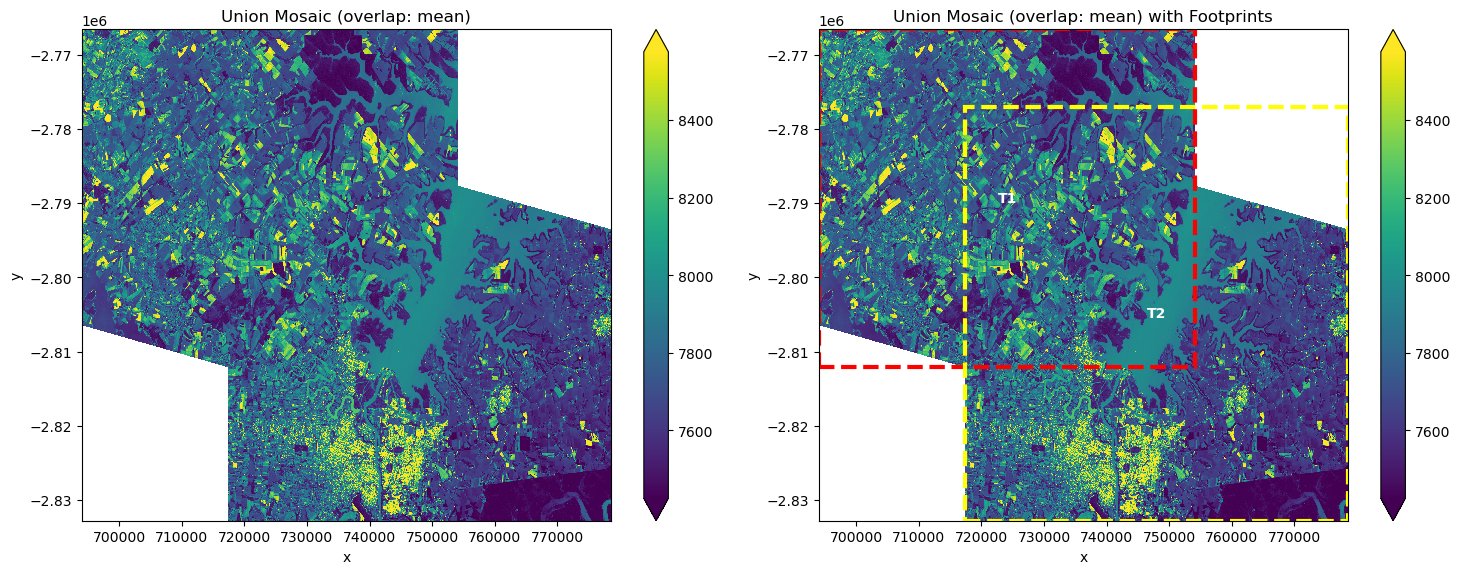

In [28]:
def plot_mosaic_with_footprints(image_paths, method='union', overlap='mean', band_idx=0):
    """Plot mosaic with overlaid tile footprints"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), dpi=100)
    
    # Create mosaic
    if method == 'union':
        mosaic = create_mosaic_union(image_paths, overlap='first', band_idx=band_idx)  # Use 'first' instead of 'mean'
    else:
        mosaic = create_mosaic_intersection(image_paths, overlap='max', band_idx=band_idx)
    title = f'{method.title()} Mosaic (overlap: {overlap})'
    
    # Plot mosaic on both axes
    for ax in [ax1, ax2]:
        mosaic.where(mosaic != 0).plot.imshow(robust=True, ax=ax, cmap='viridis')
    
    ax1.set_title(title)
    ax2.set_title(f'{title} with Footprints')
    
    # Add footprints to second plot
    colors = ['red', 'yellow', 'cyan']
    for i, path in enumerate(image_paths):
        bounds = rxr.open_rasterio(path).rio.bounds()
        rect = patches.Rectangle((bounds[0], bounds[1]), bounds[2]-bounds[0], bounds[3]-bounds[1],
                               linewidth=3, edgecolor=colors[i], facecolor='none', linestyle='--')
        ax2.add_patch(rect)
        
        center = ((bounds[0]+bounds[2])/2, (bounds[1]+bounds[3])/2)
        ax2.text(*center, f'T{i+1}', ha='center', va='center', fontweight='bold', color='white')
    
    plt.tight_layout()
    return fig, (ax1, ax2)

# Example: Union mosaic with mean overlap
plot_mosaic_with_footprints(b2_paths, method='union', overlap='mean')